In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import datasets, layers, models
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Retrieve the images

In [2]:
import pathlib
train_data_dir = 'data/paleo_dataset_new/patch_train_g_350x350'
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = 'data/paleo_dataset_new/patch_test_g_350x350'
test_data_dir = pathlib.Path(test_data_dir)

In [3]:
train_image_count = len(list(train_data_dir.glob('*/*.png')))
train_image_count

538468

In [4]:
test_image_count = len(list(test_data_dir.glob('*/*.png')))
test_image_count

70000

In [5]:
CLASS_NAMES = np.array([item.name for item in test_data_dir.glob('*')])
CLASS_NAMES

array(['AshkenaziSemi-square', 'SephardicCursive', 'SephardicSquare',
       'ItalianSemi-square', 'ByzantineSquare', 'YemeniteSquare',
       'ItalianSquare', 'ByzantineSemi-square', 'YemeniteSemiSquare',
       'ItalianCursive', 'Ashkenazi_Square', 'SephardicSemiSquare',
       'OrientalSquare', 'OrientalSemi-square', '.DS_Store'], dtype='<U20')

In [6]:
NUMBER_OF_CLASSES = len(CLASS_NAMES)
BATCH_SIZE = 32
TRAIN_STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
TEST_STEPS_PER_EPOCH = np.ceil(test_image_count/BATCH_SIZE)

### Visualisation functions

In [7]:
def show_logical_batch(image_batch, label_batch):
  plt.figure(figsize=(7,7))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [8]:
def show_numerical_batch(image_batch, label_batch):
  plt.figure(figsize=(7,7))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

### Load data

In [9]:
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

In [10]:
def get_logical_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [11]:
def get_numerical_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  numeric_label=tf.argmax(tf.cast((parts[-2] == CLASS_NAMES),dtype=tf.uint8))
  return numeric_label

In [12]:
def get_onehot_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  onehot_label=tf.cast((parts[-2] == CLASS_NAMES),dtype=tf.uint8)
  return onehot_label

In [13]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return img

In [14]:
def process_path(file_path):
  label = get_numerical_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [15]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [17]:
train_ds = prepare_for_training(train_labeled_ds, cache="./flowers.tfcache")
test_ds = prepare_for_training(test_labeled_ds)
tf_image_batch, tf_label_batch= next(iter(train_ds))
IMG_HEIGHT, IMG_WIDTH, _ =tf_image_batch[0].shape 

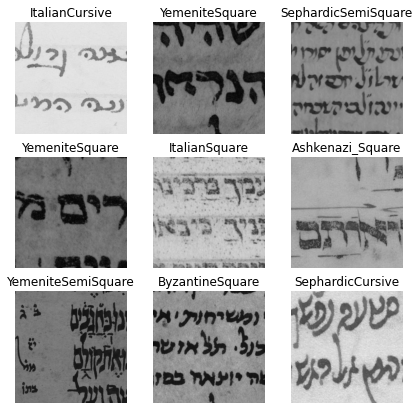

In [18]:
show_numerical_batch(tf_image_batch.numpy(), tf_label_batch.numpy())

### Model 3
#### ResNet

In [19]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(NUMBER_OF_CLASSES)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### Compile and train the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=2, 
                    validation_data=test_ds,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    validation_steps=TEST_STEPS_PER_EPOCH)

Train for 16828.0 steps, validate for 2188.0 steps
Epoch 1/2
16828/16828 [==============================] - 11970s 711ms/step - loss: 0.0502 - accuracy: 0.9852 - val_loss: 0.3406 - val_accuracy: 0.9299
Epoch 2/2
16828/16828 [==============================] - 12207s 725ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 1.4583 - val_accuracy: 0.8287


#### Evaluate the model

In [22]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
test_images, test_labels=next(iter(test_ds))
predictions=probability_model.predict(test_images)

In [23]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} \n ({})".format(CLASS_NAMES[predicted_label],
                                CLASS_NAMES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(NUMBER_OF_CLASSES))
  plt.yticks([])
  thisplot = plt.bar(range(NUMBER_OF_CLASSES), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

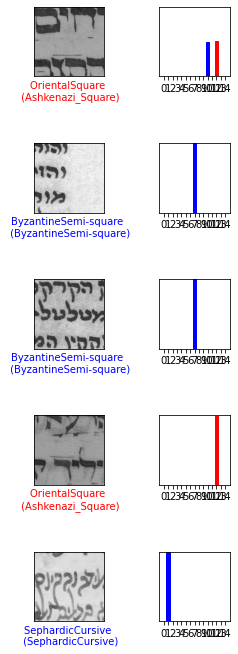

In [134]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout(pad=4.0)
plt.show()